In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 

from helpers import plotcfg
from helpers import show_results
from helpers import preprocessing
from helpers import classic_algorithms
from helpers import learning_curve

## Scenario

Quick recap: in this scenario, 1000 spectra were created, among which 50% had a main peak with SNR varying between 1 and 3 dB. In 5% of the spectra, a spurious peak of intensity ranging from 1 to 3 dB was placed at random positions in the spectra. 

In [2]:
X, y, d = pickle.load(gzip.open('../data/artificial.pickle', 'rb'), encoding='latin1')

## Model definition

The idea behind each step in the preprocessing phase is explained in the previous notebooks. Here, I just used a pipeline to stitch everything together.

In [3]:
model = make_pipeline(preprocessing.Cwt(), # Wavelet transform         
                    StandardScaler(),  
                    preprocessing.ForestSelect(k=10, trees=100), # Feature selection via Random Forest
                    linear_model.LogisticRegression())

The model was tested against the conventional methods for evaluating peak presence in gamma-ray spectra (Unidentified Second Difference and Library Correlation). I implemented these algorithms inside a sklearn Estimator class, so that they can be evaluated in the same pipeline using the same class methods as the original sklearn estimators.

Cross-validation was repeated KFold with repetitions=3 and k=10.

## Results

The performance of the ML model was vastly superior than the traditional methods with regard to aROC values, as well as with every other metric (see below).

Processing: ML model            . 17.886017084121704 s
Processing: Second difference   . 0.3761444091796875 s
Processing: Library correlation . 4.174496650695801 s




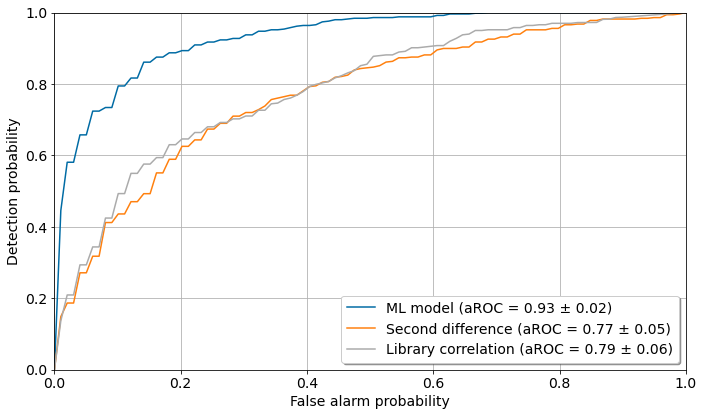

In [4]:
clf = [(u'ML model', model),
       (u'Second difference', classic_algorithms.SecondDifference(channel=50,
                                                                  fwhm=3,
                                                                  tol=1)),
       (u'Library correlation', classic_algorithms.LibCorNID(channel=50,
                                                             sensitivity=0.8,
                                                             fwhm=3,
                                                             tol=1))]

results = show_results.summary('Peak Classification',
                               clf,
                               X,
                               y,
                               cv=True,
                               n_iter=1,
                               train_sizes=np.linspace(0.05,1.00,50),
                               n_jobs=3,  # avoid hijacking all cpus
                               learnGraph=False,
                               rocGraph=True)

In [5]:
pd.DataFrame(results, columns=show_results.columns).set_index("Method")

,auROC,Accuracy,Detection rate,False alarm rate
Method,,,,
ML model,0.93 ± 0.02,0.85 ± 0.03,0.84 ± 0.06,0.15 ± 0.04
Second difference,0.77 ± 0.05,0.69 ± 0.05,0.54 ± 0.08,0.15 ± 0.05
Library correlation,0.79 ± 0.06,0.57 ± 0.04,0.17 ± 0.07,0.03 ± 0.02


However, the accuracy values of the traditional methods are far smaller than their respective aROC values. This indicates that, in contrast to the ML model, the methods default parameters may need some adjustment.

## Learning curve

The machine learning model's learning efficiency is also something. It achieves almost minimum validation error after learning from just a handful spectrum.

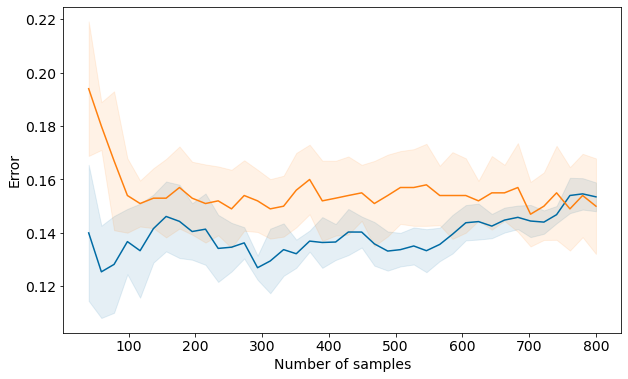

In [10]:
learning_curve.plot_learning_curve(model, X, y, cv=5, train_sizes=np.linspace(0.05,1,40))


It is noticed that the training error rate (blue) is lower than the validation error rate (orange), but that both converge to the same point in approximately 100 samples. 

## Conclusion

I showed how AI models have excellent differentiation capacity for gamma spectra, being able to surpass traditional methods in the task of detecting radionuclides when the spectrum has a low signal-to-noise ratio. 

However, I later found out that the advantage of artificial intelligence models in relation to traditional methods decreases as the signal-to-noise ratio of the spectra increases. From the tests with real spectra (^210^Pb), it is not possible to observe a statistically significant advantage of the AI models over the traditional methods when the signal-to-noise ratio is close to the detection limit.
